# Importing all the Libraries at one go

In [66]:
# Import necessary libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import operator
import joblib
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# My Functions:

In [68]:
# Function to convert datetime column to unix timestamp (seconds)
def datetounix(df):
    unixtime = []
    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))
    df['DateTime'] = unixtime
    return df

In [14]:
# Read the training and testing datasets
df_train = pd.read_csv('Train.csv', encoding='ISO-8859-1', engine='c')
df_test = pd.read_csv('Test.csv', encoding='ISO-8859-1', engine='c')

In [16]:
# Convert 'DateTime' column to datetime format
df_train['DateTime'] = pd.to_datetime(df_train['DateTime'], dayfirst=True)
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'], dayfirst=True)

In [70]:
# Extract features from DateTime for train dataset
df_train['Hour'] = df_train['DateTime'].dt.hour
df_train['DayOfWeek'] = df_train['DateTime'].dt.dayofweek
df_train['IsWeekend'] = df_train['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df_train['Month'] = df_train['DateTime'].dt.month

In [72]:
# Extract features from DateTime for test dataset
df_test['Hour'] = df_test['DateTime'].dt.hour
df_test['DayOfWeek'] = df_test['DateTime'].dt.dayofweek
df_test['IsWeekend'] = df_test['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df_test['Month'] = df_test['DateTime'].dt.month

In [74]:
# Feature importance using Extra Trees Classifier
tree_clf = ExtraTreesClassifier()

In [76]:
# Prepare training features (dropping target column 'Vehicles')
df_train_features = df_train[['Junction', 'Hour', 'DayOfWeek', 'IsWeekend', 'Month']]

X = df_train_features.values
y = df_train['Vehicles'].values


In [26]:
# Convert DateTime to unix timestamp
df_train_features = datetounix(df_train_features)

In [28]:
# Prepare input and target arrays
X = df_train_features.values
y = df_train['Vehicles'].values

In [78]:
# Fit the Extra Trees model
tree_clf.fit(X, y)

ExtraTreesClassifier()

In [79]:
# Calculate feature importances
importances = tree_clf.feature_importances_
feature_names = df_train_features.columns.tolist()

In [82]:
# Sort features by importance
feature_imp_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
indices = np.argsort(importances)[::-1]

In [84]:
# Print feature rankings
print("Feature ranking:")
for f in range(X.shape[1]):
    print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))


Feature ranking:
feature 1 : Hour (0.465996)
feature 4 : Month (0.288307)
feature 2 : DayOfWeek (0.125061)
feature 0 : Junction (0.114351)
feature 3 : IsWeekend (0.006285)


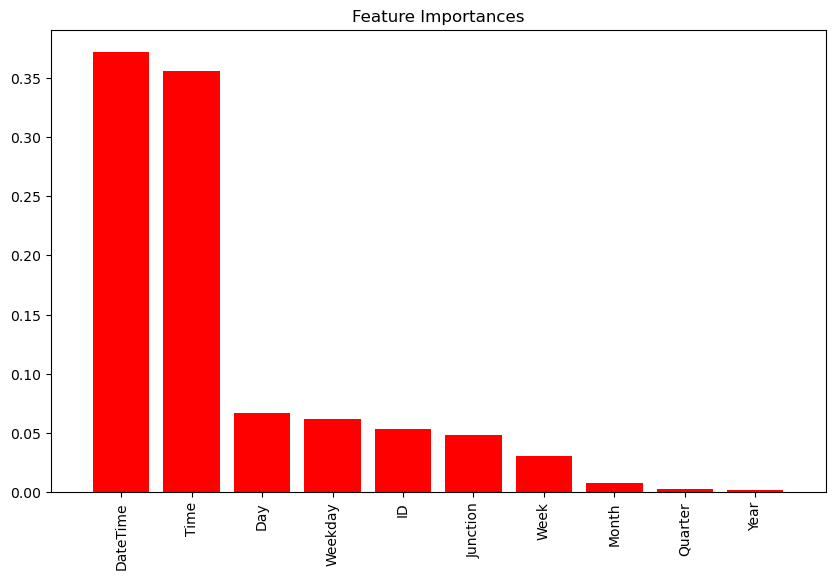

In [34]:
# Plot feature importances
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

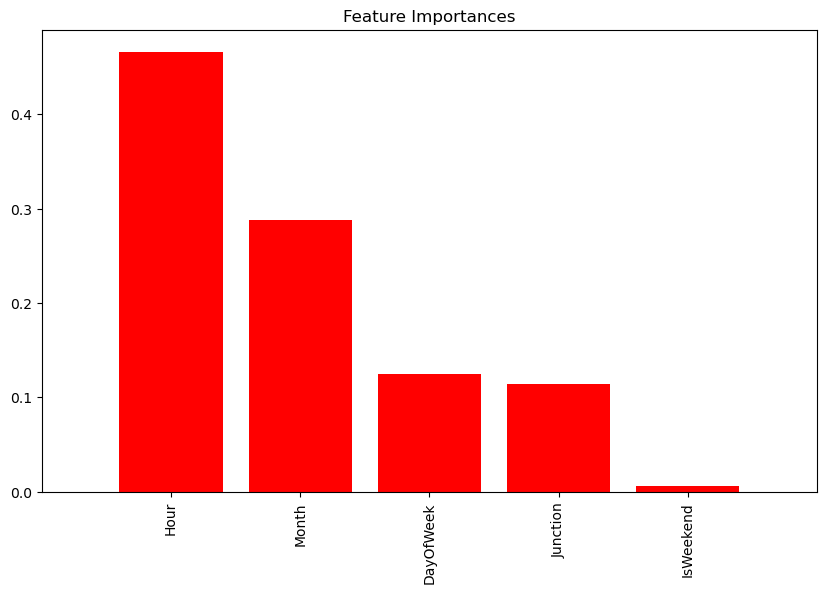

In [86]:
# Plot feature importances
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

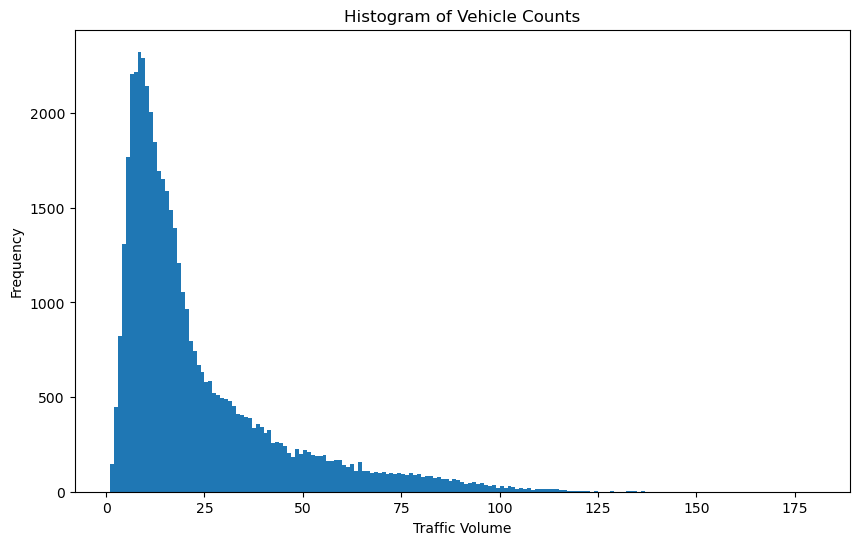

In [88]:
# Plot histogram of 'Vehicles' in train set
plt.figure(figsize=(10,6))
plt.hist(df_train['Vehicles'], bins=range(min(df_train['Vehicles']), max(df_train['Vehicles']) + 1, 1), log=False)
plt.title("Histogram of Vehicle Counts")
plt.xlabel("Traffic Volume")
plt.ylabel("Frequency")
plt.show()

# Model training with XGBoost

In [91]:
# Select features and target
features = ['Junction', 'Hour', 'DayOfWeek', 'IsWeekend', 'Month']
X = df_train[features]
y = df_train['Vehicles']

In [93]:
# Train-test split for internal validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [95]:
# Train XGBoost Regressor
model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [97]:
# Evaluate model
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE) on validation set: {mae}")

Mean Absolute Error (MAE) on validation set: 7.324096429204307


# Saving the model

In [102]:
joblib.dump(model, "traffic_forecasting_model.pkl")
print("Model saved as 'traffic_forecasting_model.pkl'")

Model saved as 'traffic_forecasting_model.pkl'


# Making Predictions on Test Data

In [107]:
# Prepare test features
X_test = df_test[features]

In [109]:
# Make predictions
df_test['PredictedVehicles'] = model.predict(X_test)

In [118]:
# Prepare final submission file
df_solution = df_test[['ID', 'PredictedVehicles']].copy()  
df_solution = df_solution.rename(columns={'PredictedVehicles': 'Vehicles'})  
df_solution.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.


# Plotting traffic volume

In [114]:
# Merge the train and predicted test data for visualization
df_train_plot = df_train[['Junction', 'Vehicles']].copy()
df_test_plot = df_test[['Junction', 'PredictedVehicles']].rename(columns={'PredictedVehicles': 'Vehicles'})

df_combined = pd.concat([df_train_plot, df_test_plot])

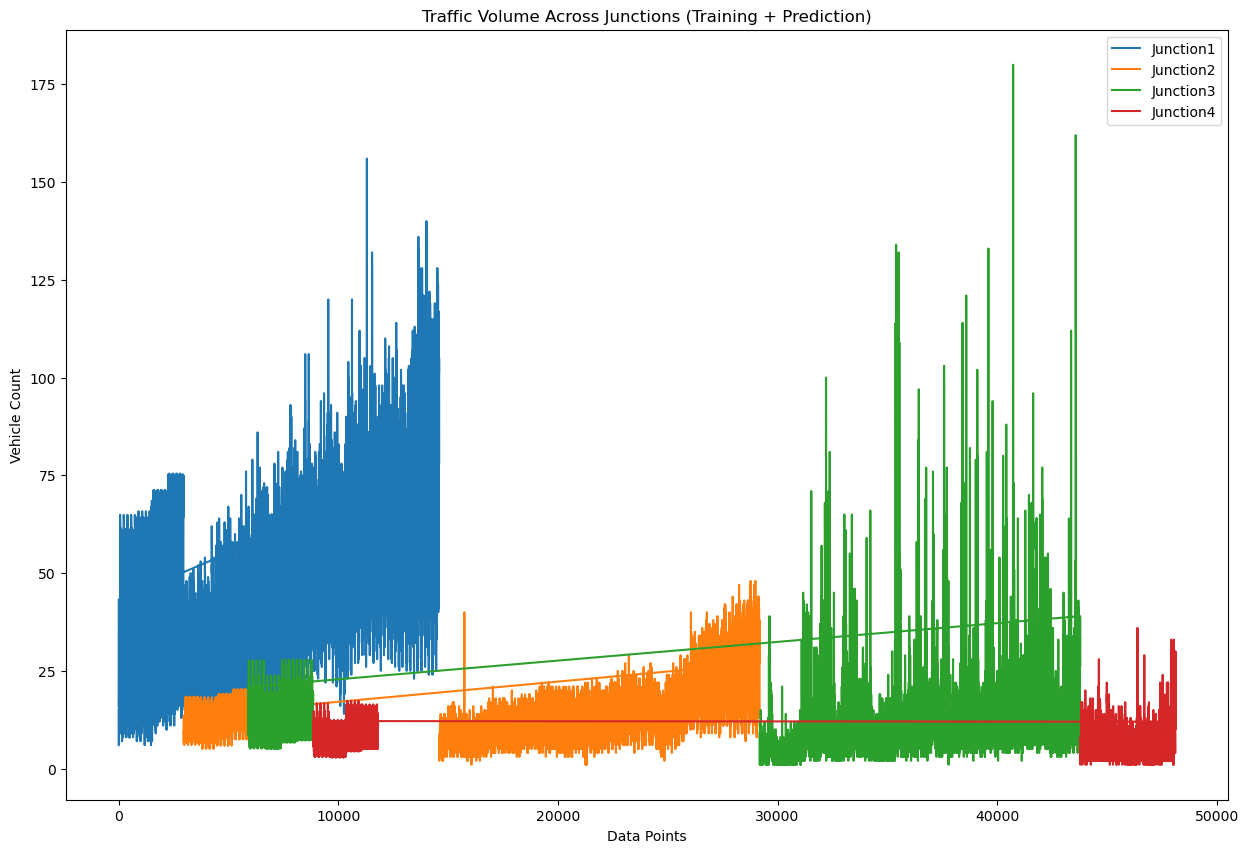

In [116]:
# Plot traffic volume
plt.figure(figsize=(15,10))
for junction in range(1, 5):
    df_combined[df_combined['Junction'] == junction]['Vehicles'].plot(legend=True, label=f'Junction{junction}')
plt.title("Traffic Volume Across Junctions (Training + Prediction)")
plt.xlabel("Data Points")
plt.ylabel("Vehicle Count")
plt.legend()
plt.show()